In [1]:
import sys, pickle, time, importlib
from pprint import pprint
import numpy as np
np.random.seed(42)
np.set_printoptions(threshold=sys.maxsize)
import scipy as spy
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [2]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# from qiskit import IBMQ
# IBMQ.save_account(TOKEN)
# IBMQ.load_account() # Load account from disk
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

# Real backend; needed for transpilation later on
#guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
from qiskit.providers.fake_provider import FakeGuadalupe

#Noisy simulator backend
noisy_sim = FakeGuadalupe()
from qiskit.opflow import Zero, One, I, X, Y, Z, PauliSumOp
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
#from qiskit.tools.monitor import job_monitor
#from qiskit.circuit import Parameter
backend = Aer.get_backend('qasm_simulator')

In [3]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
import rustworkx as rx
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

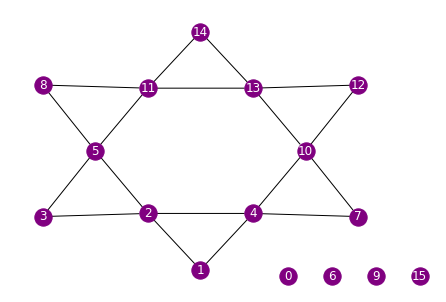

In [4]:
from qiskit_nature.problems.second_quantization.lattice import Lattice
# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [5]:
# Custom Heisenberg couplings
sys.path.append(r'.')  # may be needed if running notebook on a cloud service
from heisenberg_model import HeisenbergModel

# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)
heis_16

In [6]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

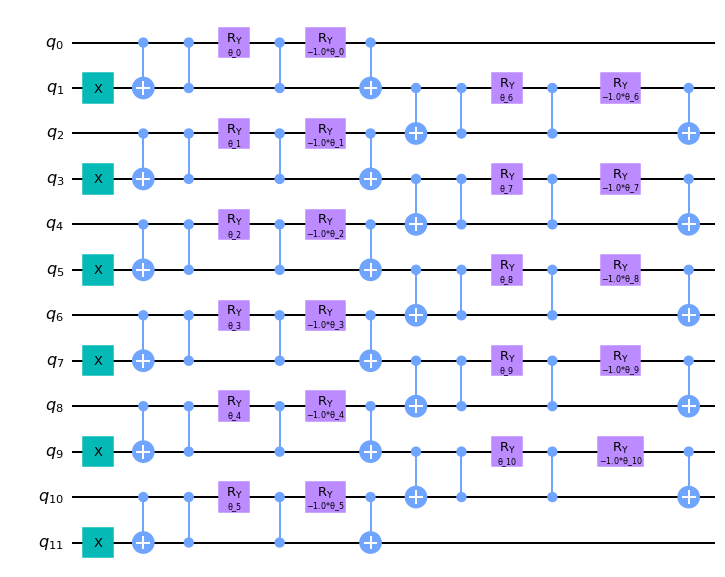

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

num_layers = 2

# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(12)
# build initial state
# ansatz_custom.h(range(0, 12, 2))

iter_layer = 0

ansatz_custom.x(range(1,12,2))

ansatz_custom.cx(range(0, 12, 2), range(1, 12, 2))
ansatz_custom.cz(range(1, 12, 2), range(0, 11, 2))

for i in range(6):
    theta=Parameter('θ_' + str(iter_layer))
    ansatz_custom.ry(theta, 2 * i)
    ansatz_custom.cz(2 * i, 2 * i + 1)
    ansatz_custom.ry(-1.0 * theta, 2 * i)
    iter_layer += 1

ansatz_custom.cx(range(0, 11, 2), range(1, 12, 2))
ansatz_custom.cx(range(1, 11, 2), range(2, 12, 2))
for i in range(5):
    theta=Parameter('θ_' + str(iter_layer))
    ansatz_custom.cz(2 * i + 2, 2 * i + 1)
    ansatz_custom.ry(theta, 2 * i + 1)
    ansatz_custom.cz(2 * i + 2, 2 * i + 1)
    ansatz_custom.ry(-1.0 * theta, 2 * i + 1)
    iter_layer += 1
    
ansatz_custom.cx(range(1, 11, 2), range(2, 12, 2))
ansatz_custom.draw("mpl", fold=250)

### Match qubit layout
The ansatz is currently defined over 12 qubits, but it will be executed on guadalupe which has 16 qubits. To make the ansatz compatible with guadalupe and the inflated Hamiltonian, we can specify the qubit layout on the real device using the transpiler (shown below). We exclude the four qubits with fewest neighbors.

number and type of gates in the cirucit: OrderedDict([('rz', 122), ('sx', 67), ('cx', 44), ('x', 6)])
number of parameters in the circuit: 11


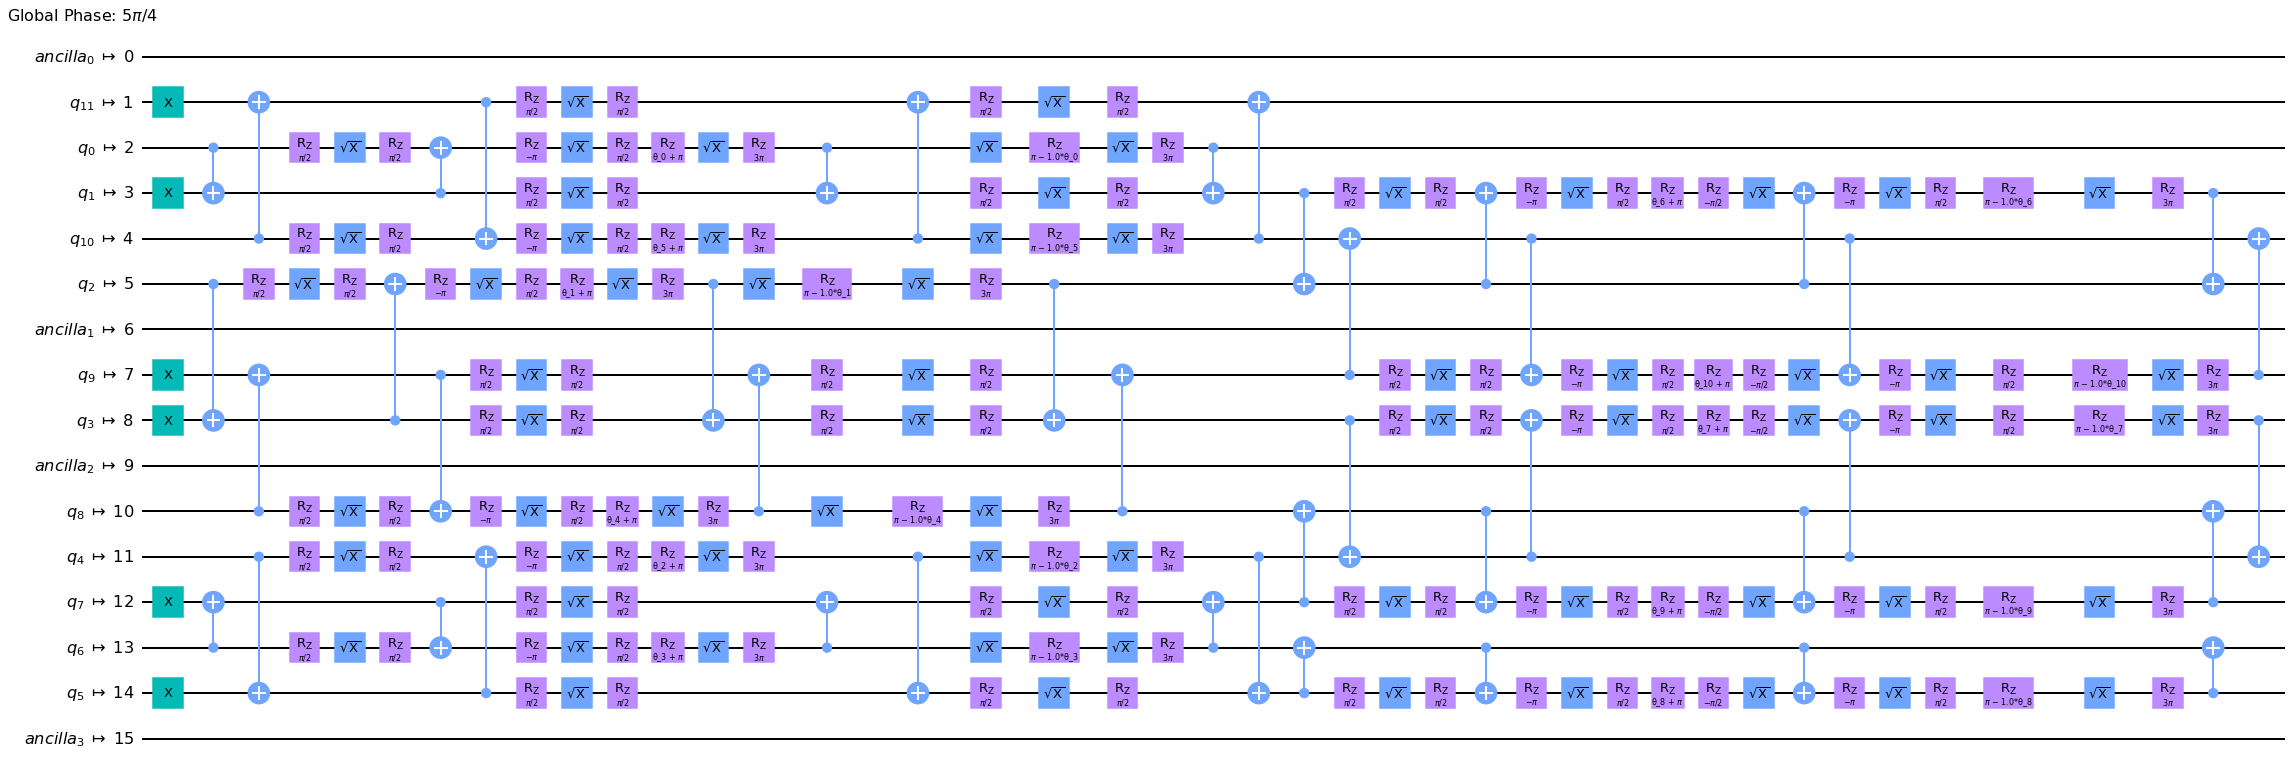

In [8]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition.
from qiskit import transpile
q_layout = [2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4, 1]
ansatz_opt = transpile(ansatz_custom, backend=noisy_sim, initial_layout=q_layout)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw("mpl", fold=400)

In [9]:
from qiskit.algorithms.optimizers import SPSA, AQGD, GradientDescent, ADAM, QNSPSA
optimizer = GradientDescent(maxiter=50, learning_rate=0.2)
# optimizer = SPSA(maxiter=100, second_order=True)

## 2-5 Define custom VQE program
The VQE calculation can be efficiently orchestrated between the quantum and classical computer using qiskit's [primitives](https://qiskit.org/documentation/apidoc/primitives.html). Below is a simple example of using the [Estimator primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-estimator) with your computer as a local simulator of a quantum computer. It's convenient to bring the components of VQE together into a custom class which we've called `CustomVQE`.

If you want more control over the measurement results and how the expectation values are computed, use the [Sampler primitive](https://qiskit.org/documentation/apidoc/primitives.html#overview-of-sampler) which will output the probabilities (or quasi-probabilities) of every measured state instead of expectation values.

In [10]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
#        x0 =np.pi/4*0.0
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

New: Making the effective Hamiltonian
We transform the given Hamiltonian to another representation by using grobal unitary transformation based on the optimized ansatz

New: Making the effective Hamiltonian
We transform the given Hamiltonian to another representation by using grobal unitary transformation based on the optimized ansatz

In [11]:
# Build effective Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

In [12]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

### Callback
It's important to know what's going on between the classical and quantum computer during the optimization. What parameter values is the classical optimizer picking? How does the convergence to the ground state energy behave?

Defining a callback function gives us a chance to peek in. A simple callback method is defined below. See [this tutorial](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html) for more information and be sure to read the classical [optimizers' docs](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) for what specific values can be extracted during optimization. For example [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html#qiskit.algorithms.optimizers.SPSA) returns: (nfev, parameters, value, stepsize, accepted).

In [13]:
# Define a simple callback function
intermediate_info = []
def callback(value):
    intermediate_info.append(value)
    print(value)

## 2-6 Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [14]:
from qiskit.primitives import Estimator

In [15]:
optimizer = GradientDescent(maxiter=500, learning_rate=0.1, tol=10e-3)
#optimizer = ADAM(maxiter=50, lr=0.2)z

class TerminationChecker:

    def __init__(self, N : int):
        self.N = N
        self.values = []

    def __call__(self, nfev, parameters, value, stepsize, accepted) -> bool:
        self.values.append(value)

        if len(self.values) > self.N:
            last_values = self.values[-self.N:]
            pp = np.polyfit(range(self.N), last_values, 1)
            slope = pp[0] / self.N

            if slope > 0:
                return True
        return False

#optimizer = SPSA(maxiter=200, last_avg=20, resamplings=1)#, termination_checker=TerminationChecker(50))
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_16])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
result = custom_vqe.compute_minimum_eigenvalue(ham_16)

print(result)
print(result.optimal_parameters)

-6.82254267888623
-6.852029888070201
-6.847059993496501
-6.804187750096774
-6.85818221197359
-6.855550576488933
-6.878764060469094
-6.857333162490699
-6.792765435865244
-6.8024769681244965
-6.810024689417756
-6.787537619432639
-15.242380510092595
-15.263580136250738
-15.237782250678094
-15.22344484996949
-15.25460811749256
-15.250268734636894
-15.260747055800312
-15.266568985559909
-15.216370176249399
-15.23128720307078
-15.22584592476288
-15.247659193150414
-17.360646296882106
-17.363812664773867
-17.35420156234986
-17.352077114222848
-17.356778046572668
-17.369582100867635
-17.360435552309166
-17.371521078706216
-17.354039624822864
-17.35562152467894
-17.35238879467192
-17.36700926349062
-17.745326774749934
-17.74346377930064
-17.741745174361956
-17.741333698053218
-17.741878344974626
-17.749772398872572
-17.74300186711755
-17.748172353700802
-17.743652916461542
-17.741749591322193
-17.739422726272064
-17.751394184168138
-17.87889793587177
-17.877813036211545
-17.876686533144788
-17.

In [16]:
from utils import *
from heisenberg_model import HeisenbergModel
#optimizer = SPSA(maxiter=100, second_order=True)

import math
import sympy

H=Hamiltonian({'ZZIIIIIIIIII':1.0, 'IZZIIIIIIIII':1.0, 'IZIZIIIIIIII':1.0, 'IIZZIIIIIIII':1.0, 'IIIZZIIIIIII':1.0, 'IIIZIZIIIIII':1.0, 'IIIIZZIIIIII':1.0, 'IIIIIZZIIIII':1.0,
               'IIIIIZIZIIII':1.0, 'IIIIIIZZIIII':1.0, 'IIIIIIIZZIII':1.0, 'IIIIIIIZIZII':1.0, 'IIIIIIIIZZII':1.0, 'IIIIIIIIIZZI':1.0, 'ZIIIIIIIIIIZ':1.0, 'IZIIIIIIIIIZ':1.0,
               'IIIIIIIIIZIZ':1.0, 'IIIIIIIIIIZZ':1.0, 'YYIIIIIIIIII':1.0, 'IYYIIIIIIIII':1.0, 'IYIYIIIIIIII':1.0, 'IIYYIIIIIIII':1.0, 'IIIYYIIIIIII':1.0, 'IIIYIYIIIIII':1.0,
               'IIIIYYIIIIII':1.0, 'IIIIIYYIIIII':1.0, 'IIIIIYIYIIII':1.0, 'IIIIIIYYIIII':1.0, 'IIIIIIIYYIII':1.0, 'IIIIIIIYIYII':1.0, 'IIIIIIIIYYII':1.0, 'IIIIIIIIIYYI':1.0,
               'YIIIIIIIIIIY':1.0, 'IYIIIIIIIIIY':1.0, 'IIIIIIIIIYIY':1.0, 'IIIIIIIIIIYY':1.0, 'XXIIIIIIIIII':1.0, 'IXXIIIIIIIII':1.0, 'IXIXIIIIIIII':1.0, 'IIXXIIIIIIII':1.0,
               'IIIXXIIIIIII':1.0, 'IIIXIXIIIIII':1.0, 'IIIIXXIIIIII':1.0, 'IIIIIXXIIIII':1.0, 'IIIIIXIXIIII':1.0, 'IIIIIIXXIIII':1.0, 'IIIIIIIXXIII':1.0, 'IIIIIIIXIXII':1.0,
               'IIIIIIIIXXII':1.0, 'IIIIIIIIIXXI':1.0, 'XIIIIIIIIIIX':1.0, 'IXIIIIIIIIIX':1.0, 'IIIIIIIIIXIX':1.0, 'IIIIIIIIIIXX':1.0})
A=Hamiltonian({"I"*12:1.0})
H=A*H*A

print(H)

{'ZZIIIIIIIIII': 1.0, 'IZZIIIIIIIII': 1.0, 'IZIZIIIIIIII': 1.0, 'IIZZIIIIIIII': 1.0, 'IIIZZIIIIIII': 1.0, 'IIIZIZIIIIII': 1.0, 'IIIIZZIIIIII': 1.0, 'IIIIIZZIIIII': 1.0, 'IIIIIZIZIIII': 1.0, 'IIIIIIZZIIII': 1.0, 'IIIIIIIZZIII': 1.0, 'IIIIIIIZIZII': 1.0, 'IIIIIIIIZZII': 1.0, 'IIIIIIIIIZZI': 1.0, 'ZIIIIIIIIIIZ': 1.0, 'IZIIIIIIIIIZ': 1.0, 'IIIIIIIIIZIZ': 1.0, 'IIIIIIIIIIZZ': 1.0, 'YYIIIIIIIIII': 1.0, 'IYYIIIIIIIII': 1.0, 'IYIYIIIIIIII': 1.0, 'IIYYIIIIIIII': 1.0, 'IIIYYIIIIIII': 1.0, 'IIIYIYIIIIII': 1.0, 'IIIIYYIIIIII': 1.0, 'IIIIIYYIIIII': 1.0, 'IIIIIYIYIIII': 1.0, 'IIIIIIYYIIII': 1.0, 'IIIIIIIYYIII': 1.0, 'IIIIIIIYIYII': 1.0, 'IIIIIIIIYYII': 1.0, 'IIIIIIIIIYYI': 1.0, 'YIIIIIIIIIIY': 1.0, 'IYIIIIIIIIIY': 1.0, 'IIIIIIIIIYIY': 1.0, 'IIIIIIIIIIYY': 1.0, 'XXIIIIIIIIII': 1.0, 'IXXIIIIIIIII': 1.0, 'IXIXIIIIIIII': 1.0, 'IIXXIIIIIIII': 1.0, 'IIIXXIIIIIII': 1.0, 'IIIXIXIIIIII': 1.0, 'IIIIXXIIIIII': 1.0, 'IIIIIXXIIIII': 1.0, 'IIIIIXIXIIII': 1.0, 'IIIIIIXXIIII': 1.0, 'IIIIIIIXXIII': 1.0, 'IIIIIIIXIXI

In [17]:
#operate cz
for i in range(5):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"XI"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"XZ"+"I"*(9-2*i):-0.5})
    print(A)
    H=A*H*A
    

for i in range(5):
    if 0.25*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 0.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):-1j*sympy.sqrt(0.5)})
        H=B*H*A
    elif 0.75*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 1.25*math.pi:
        A=Hamiltonian({"I"*(9-2*i)+"Y"+"I"*(2*i+2):1.0})
        H=A*H*A
    elif 1.25*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 1.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):-1j*sympy.sqrt(0.5)})
        H=A*H*B
    else:
        H=H

for i in range(5):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"ZI"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"ZZ"+"I"*(9-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(5):
    if 0.25*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 0.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):-1j*sympy.sqrt(0.5)})
        H=A*H*B
    elif 0.75*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 1.25*math.pi:
        A=Hamiltonian({"I"*(9-2*i)+"Y"+"I"*(2*i+2):1.0})
        H=A*H*A
    elif 1.25*math.pi < result.optimal_parameters[10-i]% (2*math.pi) < 1.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(9-2*i)+"Y"+"I"*(2*i+2):-1j*sympy.sqrt(0.5)})
        H=B*H*A
    else:
        H=H
for i in range(5):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"ZI"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"ZZ"+"I"*(9-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(5):
    A=Hamiltonian({"I"*(2*i+1)+"II"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"XI"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"IZ"+"I"*(9-2*i):0.5,"I"*(2*i+1)+"XZ"+"I"*(9-2*i):-0.5})
    print(A)
    H=A*H*A
    
#operate cz
for i in range(6):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(10-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(10-2*i):0.5,"I"*(2*i)+"XI"+"I"*(10-2*i):0.5,"I"*(2*i)+"XZ"+"I"*(10-2*i):-0.5})
    print(A)
    H=A*H*A
    

for i in range(6):
    if 0.25*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 0.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):-1j*sympy.sqrt(0.5)})
        H=B*H*A
    elif 0.75*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 1.25*math.pi:
        A=Hamiltonian({"I"*(10-2*i)+"Y"+"I"*(2*i+1):1.0})
        H=A*H*A
    elif 1.25*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 1.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):-1j*sympy.sqrt(0.5)})
        H=A*H*B
    else:
        H=H

for i in range(6):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(10-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(10-2*i):0.5,"I"*(2*i)+"ZI"+"I"*(10-2*i):0.5,"I"*(2*i)+"ZZ"+"I"*(10-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(6):
    if 0.25*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 0.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):-1j*sympy.sqrt(0.5)})
        H=A*H*B
    elif 0.75*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 1.25*math.pi:
        A=Hamiltonian({"I"*(10-2*i)+"Y"+"I"*(2*i+1):1.0})
        H=A*H*A
    elif 1.25*math.pi < result.optimal_parameters[5-i]% (2*math.pi) < 1.75*math.pi:
        A=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):1j*sympy.sqrt(0.5)})
        B=Hamiltonian({"I"*12:sympy.sqrt(0.5),"I"*(10-2*i)+"Y"+"I"*(2*i+1):-1j*sympy.sqrt(0.5)})
        H=B*H*A
    else:
        H=H
        
for i in range(6):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(10-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(10-2*i):0.5,"I"*(2*i)+"ZI"+"I"*(10-2*i):0.5,"I"*(2*i)+"ZZ"+"I"*(10-2*i):-0.5})
    print(A)
    H=A*H*A
        
for i in range(6):
    A=Hamiltonian({"I"*(2*i)+"II"+"I"*(10-2*i):0.5,"I"*(2*i)+"IZ"+"I"*(10-2*i):0.5,"I"*(2*i)+"XI"+"I"*(10-2*i):0.5,"I"*(2*i)+"XZ"+"I"*(10-2*i):-0.5})
    print(A)
    H=A*H*A
        
        
print(H)

{'IIIIIIIIIIII': 0.5, 'IXIIIIIIIIII': 0.5, 'IIZIIIIIIIII': 0.5, 'IXZIIIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIXIIIIIIII': 0.5, 'IIIIZIIIIIII': 0.5, 'IIIXZIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIXIIIIII': 0.5, 'IIIIIIZIIIII': 0.5, 'IIIIIXZIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIIXIIII': 0.5, 'IIIIIIIIZIII': 0.5, 'IIIIIIIXZIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIIIIXII': 0.5, 'IIIIIIIIIIZI': 0.5, 'IIIIIIIIIXZI': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIZIIIIIIIII': 0.5, 'IZIIIIIIIIII': 0.5, 'IZZIIIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIZIIIIIII': 0.5, 'IIIZIIIIIIII': 0.5, 'IIIZZIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIZIIIII': 0.5, 'IIIIIZIIIIII': 0.5, 'IIIIIZZIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIIIZIII': 0.5, 'IIIIIIIZIIII': 0.5, 'IIIIIIIZZIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIIIIIIIZI': 0.5, 'IIIIIIIIIZII': 0.5, 'IIIIIIIIIZZI': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIZIIIIIIIII': 0.5, 'IZIIIIIIIIII': 0.5, 'IZZIIIIIIIII': -0.5}
{'IIIIIIIIIIII': 0.5, 'IIIIZIIIIIII': 0.5, 'IIIZIIIIII

In [18]:
#apply for the 16 qubits device 


Heff=Hamiltonian({"I"*16:0.0})
for operator, coeff in H.items():
    operator=operator+"I"*4
    operator_dum=Hamiltonian({"I"*16:1.0})
    j=0
    for i in q_layout:
        operator_dum=operator_dum*Hamiltonian({"I"*(i)+operator[j]+"I"*(15-i):1.0})
        j+=1
    Heff=Heff+operator_dum*Hamiltonian({"I"*16: coeff})
print(Heff)

n=0
Heff_operator=""

Heff_coeff= np.zeros((55), dtype="complex")

for operator, coeff in Heff.items():
    Heff_operator= Heff_operator + operator if Heff_operator == "" else Heff_operator+" "+operator 
    Heff_coeff[n]=coeff
    print("operator=",operator)
    print("coeff[",n,"]",Heff_coeff[n])
    n+=1

Heff_operator2 = Heff_operator.split()
    
import logging
import numpy as np
from fractions import Fraction
from typing import Optional

from qiskit_nature.second_q.operators import SpinOp
from qiskit_nature.problems.second_quantization.lattice.lattices import Lattice
from qiskit_nature.problems.second_quantization.lattice.models.lattice_model import LatticeModel

from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

#SparsePauliOp(Heff_operator2,np.array(Heff_coeff))
ham_eff=PauliSumOp(SparsePauliOp(Heff_operator2,np.array(Heff_coeff)))

#ham_eff=SpinOp({"X_0":0.0},spin=Fraction(1,2), num_spins=16)
#for operator, coeff in Heff.items():
#    operator_dum2=""
##    for i in range(len(operator)):
 #       if operator[i]=="I":
#            continue
#        else:
#            operator_dum2 += operator[i] + "_" + str(i) if operator_dum2 == "" else " " + operator[i] + "_" + str(i)
#    ham_eff = ham_eff + SpinOp({operator_dum2: coeff}, num_spins=16)

print(ham_eff)
print("upforward is ham_eff")


{'IIIIIIIIIIIIIIII': 0.0, 'IIZZIIIIIIIIIIII': (1+0j), 'IIIZIZIIIIIIIIII': (1+0j), 'IIIZIIIIZIIIIIII': (1+0j), 'IIIIIZIIZIIIIIII': (1+0j), 'IIIIIIIIZIIZIIII': (1+0j), 'IIIIIIIIZIIIIIZI': (1+0j), 'IIIIIIIIIIIZIIZI': (1+0j), 'IIIIIIIIIIIIIZZI': (1+0j), 'IIIIIIIIIIIIZIZI': (1+0j), 'IIIIIIIIIIIIZZII': (1+0j), 'IIIIIIIIIIZIZIII': (1+0j), 'IIIIIIIZIIIIZIII': (1+0j), 'IIIIIIIZIIZIIIII': (1+0j), 'IIIIZIIZIIIIIIII': (1+0j), 'IZIIIIIZIIIIIIII': (1+0j), 'IZZIIIIIIIIIIIII': (1+0j), 'IZIZIIIIIIIIIIII': (1+0j), 'IZIIZIIIIIIIIIII': (1+0j), 'IIIYIIIIYIIIIIII': (1+0j), 'IIIIIIIIYIIIIIYI': (1+0j), 'IIIIIIIIIIIIYIYI': (1+0j), 'IIIIIIIYIIIIYIII': (1+0j), 'IYYIIIIIIIIIIIII': (1+0j), 'IYIYIIIIIIIIIIII': (1+0j), 'IYIIIIIYIIIIIIII': (1+0j), 'IIIXIIIIXIIIIIII': (1+0j), 'IIIIIIIIXIIIIIXI': (1+0j), 'IIIIIIIIIIIIXIXI': (1+0j), 'IIIIIIIXIIIIXIII': (1+0j), 'IXXIIIIIIIIIIIII': (1+0j), 'IXIXIIIIIIIIIIII': (1+0j), 'IXIIIIIXIIIIIIII': (1+0j), 'IIIYIYIIIIIIIIII': (1+0j), 'IIIXIXIIIIIIIIII': (1+0j), 'IIIIIIIIYIIYIIII': (1

In [19]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_eff])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)
print("VQE Lunning...")
# Run the custom VQE function and monitor execution time
result = custom_vqe.compute_minimum_eigenvalue(ham_eff)

print(result)
print(H)

VQE Lunning...
-9.939168354261913
-9.938427756416841
-9.958651143971984
-9.91792810747887
-9.980850407596222
-9.995855904359699
-9.980204098315598
-9.973941106397623
-9.917061995752066
-9.907840524432176
-9.905226963928113
-9.909757718045928
-17.618640593871834
-17.62063625680714
-17.6173300909967
-17.619973262469713
-17.632551768416597
-17.629827853939975
-17.62137872013233
-17.618462136976095
-17.61379109824666
-17.61473383412568
-17.60708466806489
-17.62380327548745
-17.90698045690301
-17.907457187533907
-17.905382094410637
-17.907530833278592
-17.90860968938786
-17.90456059303853
-17.90999692699565
-17.90747507622764
-17.904500959295532
-17.91060542787217
-17.906618376785485
-17.910279027062774
-17.951170565066086
-17.951269325489896
-17.949838827375928
-17.95158261955446
-17.952914803940697
-17.950567318592597
-17.95305642779727
-17.951487232303986
-17.949541061602243
-17.953295348028888
-17.950073756379446
-17.953715035972618
-17.97312533496607
-17.973147621745262
-17.97220549350

In the print out above, the ground state energy is under "eigenvalue", and the optimal choice of parameters that goes with that energy is under "optimal_parameters". Let's plot the energy convergence data the callback function acquired.

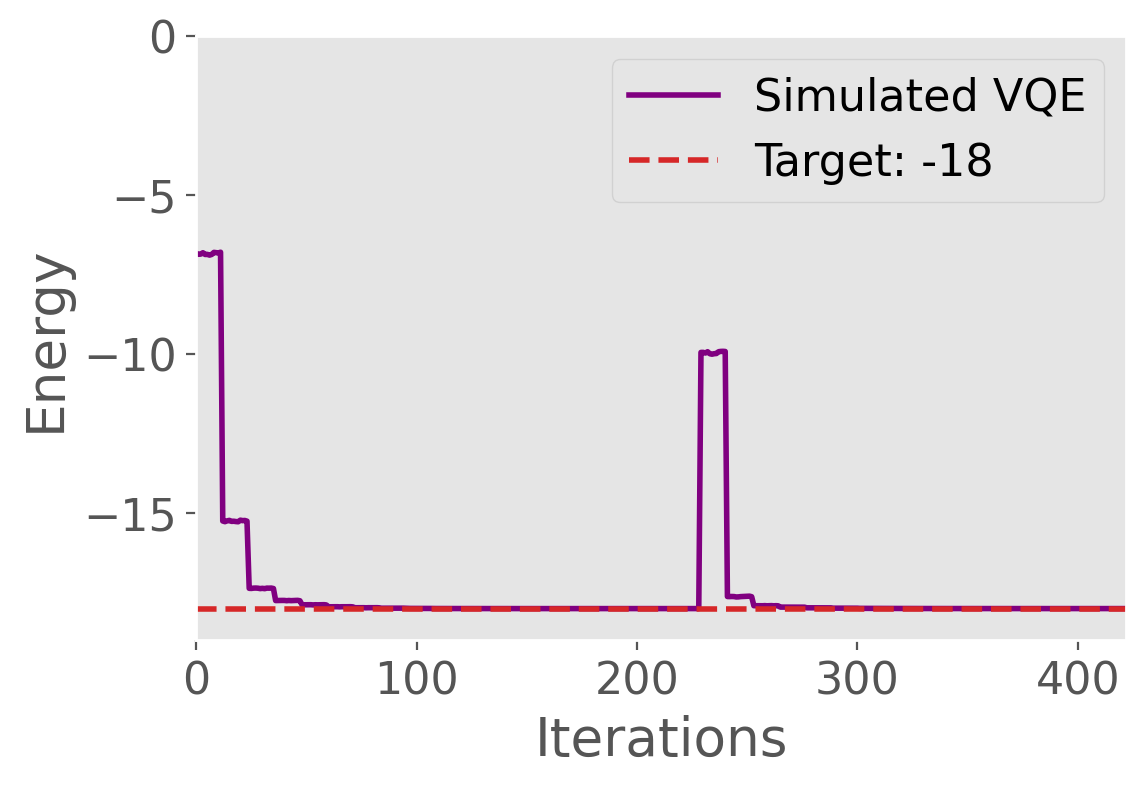

In [20]:
gs_energy = -18
# Figureを設定
fig = plt.figure(dpi=200)

# グラフ描画領域を追加
ax = fig.add_subplot(111)

ax.set_ylim(-19.00,0.00)
ax.set_xlim(0,min(2200, len(intermediate_info)))

plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

The true ground state energy is -18.0. As a metric for how well the VQE found the ground state energy, we will compute the relative difference between -18.0 and what we just achieved with VQE. This will be the metric of performance in the judging criteria, though it's important to note that it's not the only useful metric when working with VQE. Remember that the lower the relative error the higher you will score.

In [21]:
def rel_err(target, measured):
    return abs((target - measured) / target)

# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -17.9977646287
Relative error: 0.00012419


# Try GSE

In [22]:
from dsp import *
from gse import *

In [23]:
# qr_vqe = QuantumRegister(num_qubits)
# qc_vqe = QuantumCircuit(qr_vqe)
qc_vqe = ansatz_opt.bind_parameters(result.optimal_parameters)

In [24]:
from qiskit.compiler import transpile
basis_gates = ["rz", "sx", "cx"]
optimization_level = 3
qc_vqe = transpile(qc_vqe, basis_gates=basis_gates, optimization_level=optimization_level)
# qc_vqe.draw("mpl")
qc_vqe_inv = transpile(qc_vqe.inverse(), basis_gates=basis_gates, optimization_level=optimization_level)

In [25]:
sigma_list=[(qc_vqe, 1.0), (qc_vqe, 1.0)]
sigma_list_inv=[(qc_vqe_inv, 1.0), (qc_vqe_inv, 1.0)]
pauli_list = [(H, 0), (H, 1)]

In [26]:
q_layout

[2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4, 1]

In [30]:
z_index = 11
connection_order = [[i+1, i] for i in range(12 - 1)[::-1]]
print(connection_order)

[[11, 10], [10, 9], [9, 8], [8, 7], [7, 6], [6, 5], [5, 4], [4, 3], [3, 2], [2, 1], [1, 0]]


In [31]:
qcs_H_tilde, qcs_S_tilde = make_qcs_gse_dsp_ancilla(hamiltonian=H, 
                                                    sigma_list=sigma_list, 
                                                    sigma_list_inv=sigma_list_inv,
                                                    pauli_list=pauli_list, 
                                                    measurement=True, # =False, 
                                                    z_index=z_index, 
                                                    connection_graph=connection_order, 
                                                    barrier=False)
print("the number of quantum circuits in qcs_H_tilde:", len(qcs_H_tilde))
print("the number of quantum circuits in qcs_S_tilde:", len(qcs_H_tilde))

CircuitError: 'Number of items in qubits parameter (16) does not match number of qubits in the circuit (12).'

In [ ]:
### Transpile the quantum circuit# from qiskit.transpiler.passes import RemoveBarriers
qcs_H_tilde = [transpile(qc, basis_gates=basis_gates, optimization_level=0) for qc in qcs_H_tilde]
qcs_S_tilde = [transpile(qc, basis_gates=basis_gates, optimization_level=0) for qc in qcs_S_tilde]

In [ ]:
from qiskit import execute
job_qcs_H_tilde = execute(qcs_H_tilde, backend=backend, shots=shots, optimization_level=0, initial_layout=q_layout+[0])
job_qcs_S_tilde = execute(qcs_S_tilde, backend=backend, shots=shots, optimization_level=0, initial_layout=q_layout+[0])

In [ ]:
results_H_tilde = job_qcs_H_tilde.result()
results_S_tilde = job_qcs_S_tilde.result()
hists_H_tilde = results_H_tilde.get_counts()
hists_S_tilde = results_S_tilde.get_counts()

In [ ]:
eig_vals, eig_vecs, H_tilde, S_tilde = compute_energy_gse_dsp_ancilla(hists_H_tilde=hists_H_tilde,
                                                                      hists_S_tilde=hists_S_tilde,
                                                                      hamiltonian=H,
                                                                      sigma_list=sigma_list,
                                                                      pauli_list=pauli_list,
                                                                      hist_type="raw",
                                                                      return_all=True)
max_energy = len(H)
eig_vals_lower_bounded = eig_vals.real[- max_energy < eig_vals.real]
eig_vals_bounded = eig_vals_lower_bounded[eig_vals_lower_bounded < max_energy]
energy = np.sort(eig_vals_bounded)[0]
print("Estimated ground state energy by GSE (power subspace):", energy)
print()
print("physically meaningful eigen values")
pprint(eig_vals_bounded)
# print()

## 3-1 Qiskit runtime (cloud simulator)

Next we demonstrate how to run VQE using [qiskit_ibm_runtime](https://github.com/Qiskit/qiskit-ibm-runtime) **which has different syntax from qiskit terra's runtime**. The qiskit_ibm_runtime module includes the same programming model as qiskit terra, but qiskit_ibm_runtime has access to a cloud simulator and more importantly the ibmq_guadalupe device. To learn more about qiskit_ibm_runtime check out these tutorials from the docs: [a tutorial on the estimator](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-estimator.ipynb) and [a tutorial on the sampler](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-sampler.ipynb).

We will use all the same VQE components we've built up so far, but the syntax for executing on the hardware is wrapped in [a session](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/sessions/) as shown in the following cells.

We first demonstrate running VQE with the cloud simulator backend to check everything is working correctly. This may take a few minutes. After running on the cloud simulator, we make a simple switch of backends to the real ibmq_guadalupe device to get the final result. Depending on how your VQE is setup, this may take a couple hours.

In [30]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService(channel='ibm_quantum')

In [31]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'simulator_statevector'

Simulators: [<IBMBackend('simulator_mps')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_extended_stabilizer')>]


In [32]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [33]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

In [35]:
# Setup Estimator with session error handling reconnection work around
start = time.perf_counter()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time.perf_counter()
print(f'execution time (s): {end - start:.2f}')

KeyboardInterrupt: 

In [ ]:
# # Setup Estimator (standard method)
# start = time()
# with Session(service=service, backend=backend) as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)
#     # Set up algorithm
#     custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
#     # Run algorithm
#     result = custom_vqe.compute_minimum_eigenvalue(ham_16)
# end = time()
# print(f'execution time (s): {end - start:.2f}')

In [ ]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
rel_error = rel_err(gs_energy, result.eigenvalue)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

## 3-2 Qiskit runtime Real backend (ibmq_guadalupe)

If our `qiskit_ibm_runtime` code is working on the cloud simulator backend, we can simply change the backend to the ibmq_guadalupe to run on the real backend. This may take a couple hours. Your performance score will be determined by the calculated relative error between the true ground state energy of -18.0 and the measured energy from the real ibmq_guadalupe backend.

In [ ]:
# service = QiskitRuntimeService(channel='ibm_quantum')
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q-community/ibmquantumawards/open-science-22',
)

backend = 'ibmq_guadalupe'

In [ ]:
# Define a simple callback function
intermediate_info_real_backend = []
def callback_real(value):
        intermediate_info_real_backend.append(value)

In [ ]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")

In [ ]:
# Setup Estimator with session error handling reconnection work around
start = time.perf_counter()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time.perf_counter()
print(f'execution time (s): {end - start:.2f}')

In [ ]:
# # Setup Estimator
# start = time()
# with Session(service=service, backend=backend) as session:
#     # Prepare primitive
#     rt_estimator = RuntimeEstimator(session=session)
#     # set up algorithm
#     custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_real)
#     # run algorithm
#     result = custom_vqe.compute_minimum_eigenvalue(ham_16)
# end = time()
# print(f'execution time (s): {end - start:.2f}')

In [ ]:
plt.plot(intermediate_info_real_backend, color='purple', lw=2, label='VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

## 3-3 Performance Score
Compute the relative error between the expected ground state energy and the VQE result.

In [ ]:
# Compute the relative error between the expected ground state energy and the measured
computed_gse = intermediate_info_real_backend[-1]

print(f'Expected ground state energy: {gs_energy:.8f}')
print(f'Computed ground state energy: {computed_gse:.8f}')
print(f'Relative error: {100 * rel_err(gs_energy, computed_gse):.8f} %')

# Considerations
Feeling stuck? Below are a list of questions and considerations to help spark new ideas for your VQE implementation.

**Ansatz.** Carefully consult research literature for the best approach of ansatz selection. How might errors affect your ansatz? How many parameters are needed to reach the ground state? What properties of the Hamiltonian could help simplify the ansatz?

**Classical optimizer.** What optimizer will pair well with for your choice of ansatz and measurement parameters? What noise do you expect from the quantum computer, and what noise sensitivity can the classical optimizer withstand? How many iterations will be needed?

**Initial state/point.** Is there an initial quantum state that really helps things get going? What about a starting point for the circuit parameters? Does the VQE give the same results for different initial parameter values?

**Number of measurements.** How does the number of shots affect the VQE's convergence to the ground state energy? The expectation value of the Hamiltonian is a sum of the expectation values of each of the 54 terms. What is the least number of circuit executions necessary to compute the expectation value of the Hamiltonian? What is the optimal number of circuit executions for stable convergence?

**Many qubits.** Working with larger numbers of qubits is its own challenge. For example, what's a concise way of writing down or even visualizing the 4096 digit ground state? What methods and techniques will not scale well? What techniques would scale well if this VQE were to be done on a larger system? How can you reduce your execution time of the real device?

**Error mitigation.** What errors are most prevalent, and how can you reduce them efficiently? What error mitigation techniques will scale well?

In [ ]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table